In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip  "/content/drive/My Drive/train.zip" -d "/content/dataset"

Archive:  /content/drive/My Drive/train.zip
   creating: /content/dataset/train/Battery/
  inflating: /content/dataset/train/Battery/battery_0.jpg  
  inflating: /content/dataset/train/Battery/battery_1.jpg  
  inflating: /content/dataset/train/Battery/battery_10.jpg  
  inflating: /content/dataset/train/Battery/battery_100.jpg  
  inflating: /content/dataset/train/Battery/battery_101.jpg  
  inflating: /content/dataset/train/Battery/battery_102.jpg  
  inflating: /content/dataset/train/Battery/battery_104.jpg  
  inflating: /content/dataset/train/Battery/battery_107.jpg  
  inflating: /content/dataset/train/Battery/battery_109.jpg  
  inflating: /content/dataset/train/Battery/battery_11.jpg  
  inflating: /content/dataset/train/Battery/battery_110.jpg  
  inflating: /content/dataset/train/Battery/battery_111.jpg  
  inflating: /content/dataset/train/Battery/battery_112.jpg  
  inflating: /content/dataset/train/Battery/battery_113.jpg  
  inflating: /content/dataset/train/Battery/batte

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/train",
    seed=23,
    shuffle=False,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
dataset

Found 2400 files belonging to 10 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
class_names = dataset.class_names
class_names

['Battery',
 'Keyboard',
 'Microwave',
 'Mobile',
 'Mouse',
 'PCB',
 'Player',
 'Printer',
 'Television',
 'Washing Machine']

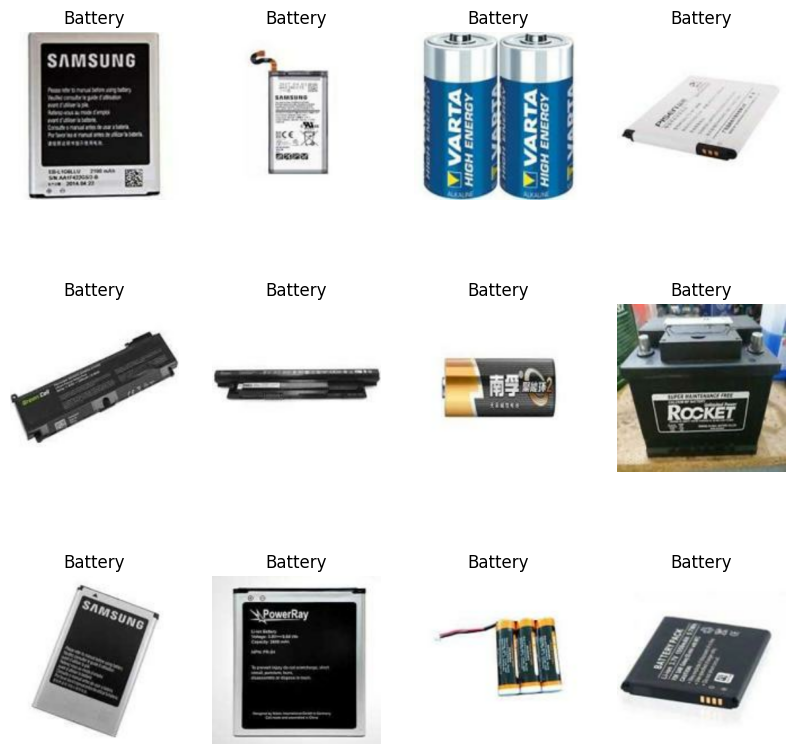

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
data_augmentation = tf.keras.Sequential([

    # Rescale the pixel values from [0, 255] to [0, 1]
    tf.keras.layers.Rescaling(1./255),

    # Randomly flip the images horizontally and vertically
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),

    # Apply random rotation within a range of ±20% of a full rotation
    tf.keras.layers.RandomRotation(0.2),

    # Apply random zoom to the images
    tf.keras.layers.RandomZoom(0.2),

    # Randomly change the brightness of the image
    tf.keras.layers.RandomBrightness(factor=0.2)
])


In [ ]:
model = tf.keras.Sequential([

    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='softmax')
])
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()


model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])
history = model.fit(train_ds, validation_data=test_ds, epochs=10)

Epoch 1/10
 1/60 ━━━━━━━━━━━━━━━━━━━━ 16:47 17s/step - accuracy: 0.0000e+00 - loss: 34.5276

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


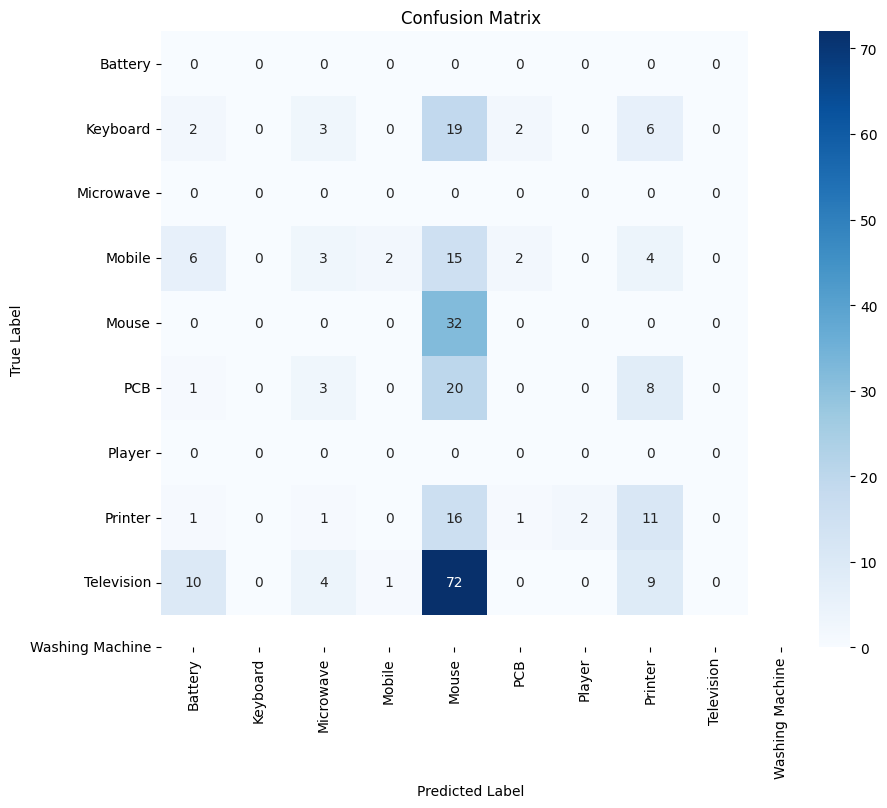

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define the class names from your dataset
class_names = dataset.class_names

# Get the true labels and predicted labels from the test dataset
y_true = []
y_pred = []

# Make predictions on the test dataset
for images, labels in test_ds:
    predictions = model.predict(images)  # Predict on batch
    y_pred.extend(np.argmax(predictions, axis=1))  # Get the predicted class indices
    y_true.extend(labels.numpy())  # Append the true labels as numpy arrays

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Convert lists to numpy arrays for metric calculations
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate Precision, Recall, F1-Score (macro, weighted, or per-class can be specified)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-Score (macro): {f1:.4f}")

# Specify labels to avoid mismatch and use `zero_division=0` to avoid undefined warnings
num_classes = len(class_names)  # Should be 10
labels = list(range(num_classes))

# Detailed classification report (per-class precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, labels=labels, zero_division=0))


Accuracy: 0.4609
Precision (macro): 0.2727
Recall (macro): 0.2413
F1-Score (macro): 0.2228

Classification Report:
                 precision    recall  f1-score   support

        Battery       0.00      0.00      0.00        32
       Keyboard       0.00      0.00      0.00         0
      Microwave       0.77      0.53      0.63        32
         Mobile       0.00      0.00      0.00         0
          Mouse       0.00      0.00      0.00         0
            PCB       0.38      1.00      0.55        64
         Player       0.50      0.12      0.20        32
        Printer       0.00      0.00      0.00         0
     Television       0.80      0.52      0.63        64
Washing Machine       0.00      0.00      0.00        32

      micro avg       0.46      0.46      0.46       256
      macro avg       0.25      0.22      0.20       256
   weighted avg       0.45      0.46      0.40       256



In [ ]:
Inception_V3_Model = tf.keras.applications.InceptionV3(input_shape=(256, 256, 3),
                                             weights='imagenet',
                                             include_top=False,
                                             classes=numClasses)

for layer in Inception_V3_Model.layers[:249]:
    layer.trainable = False

for layer in Inception_V3_Model.layers[249:]:
    layer.trainable = True

last_output = data_augmentation(Inception_V3_Model.output)
maxpooled_output = tf.keras.layers.Flatten()(last_output)

x = tf.keras.layers.Dense(1024, activation='relu')(maxpooled_output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

inception_model = tf.keras.Model(inputs=Inception_V3_Model.input, outputs=x)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

inception_model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])

history = inception_model.fit(train_dataset, epochs=10)

NameError: name 'numClasses' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Visualize the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
baseModel = tf.keras.applications.ResNet152(input_shape=(256, 256, 3), weights='imagenet',
                                           include_top=False, classes=numClasses)

for layers in baseModel.layers:
    layers.trainable=False

last_output = baseModel.layers[-1].output

x = tf.keras.layers.Dropout(0.5)(last_output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input, outputs=x)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])

epochs=10
callbacks = tf.keras.callbacks.EarlyStopping(patience=2)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[callbacks])

In [ ]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)